## 1. Mount Google Drive & GPU Check

In [ ]:
# ==============================================================================
# SECTION 1: Mount Google Drive & GPU Check
# ==============================================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check GPU
import subprocess
subprocess.run(['nvidia-smi'])

# Install dependencies
subprocess.run(['pip', 'install', 'ultralytics', 'pandas', 'matplotlib', 'seaborn', '-q'])

import torch
print(f"[OK] PyTorch: {torch.__version__}")
print(f"[OK] CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"[OK] GPU: {torch.cuda.get_device_name(0)}")

Mounted at /content/drive
[OK] PyTorch: 2.8.0+cu126
[OK] CUDA available: True
[OK] GPU: Tesla T4


In [ ]:
# Install dependencies
!pip install ultralytics pandas matplotlib seaborn -q

import torch
print(f"[OK] PyTorch: {torch.__version__}")
print(f"[OK] CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"[OK] GPU: {torch.cuda.get_device_name(0)}")

[OK] PyTorch: 2.8.0+cu126
[OK] CUDA available: True
[OK] GPU: Tesla T4


##  2. ExperimentTrainer Class Definition

In [ ]:
# ==============================================================================
# SECTION 2: ExperimentTrainer Class Definition
# ==============================================================================

import torch
import json
import csv
import time
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')


class ExperimentTrainer:
    """
    Unified trainer for object detection experiments.
    Supports YOLOv8 with dataset tracking and full hyperparameter control.
    """

    def __init__(
        self,
        experiment_name: str,
        model_type: str = 'yolov8',
        base_dir: str = '/content/drive/MyDrive/cv_project/04_experiments',
        model_family_dir: str = '01_yolov8'
    ):
        self.experiment_name = experiment_name
        self.model_type = model_type.lower()

        # Paths
        self.base_dir = Path(base_dir)
        self.model_family_dir = self.base_dir / model_family_dir
        self.model_family_dir.mkdir(parents=True, exist_ok=True)

        # Master files (shared across all model families)
        self.master_log = self.base_dir / 'all_experiments_log.csv'
        self.master_best_model = self.base_dir / 'best_model_overall.json'

        # Model-family specific files
        family_name = model_family_dir.split('_', 1)[1]
        self.family_log = self.model_family_dir / f'{family_name}_experiments_log.csv'
        self.family_best_model = self.model_family_dir / f'{family_name}_best_model.json'

        # Auto-increment experiment number
        self.experiment_id = self._get_next_experiment_id()
        self.experiment_dir = self.model_family_dir / self.experiment_id
        self.experiment_dir.mkdir(parents=True, exist_ok=True)

        # Device detection
        self.device = self._detect_device()

        # Timing
        self.start_time = None
        self.end_time = None

        # Model
        self.model = None
        self.best_metrics = {}

        print(f"[OK] Experiment initialized")
        print(f"  Name: {self.experiment_name}")
        print(f"  ID: {self.experiment_id}")
        print(f"  Model: {self.model_type.upper()}")
        print(f"  Device: {self.device}")
        print(f"  Save directory: {self.experiment_dir}\n")

    def _get_next_experiment_id(self) -> str:
        """Auto-increment experiment number"""
        existing_experiments = list(self.model_family_dir.glob('exp_*'))

        if not existing_experiments:
            exp_num = 1
        else:
            numbers = []
            for exp_path in existing_experiments:
                try:
                    num_str = exp_path.name.split('_')[1]
                    numbers.append(int(num_str))
                except (IndexError, ValueError):
                    continue

            exp_num = max(numbers) + 1 if numbers else 1

        return f"exp_{exp_num:03d}_{self.experiment_name}"

    def _detect_device(self) -> str:
        """Detect best available device (CUDA > MPS > CPU)"""
        if torch.cuda.is_available():
            device = 'cuda'
            gpu_name = torch.cuda.get_device_name(0)
            print(f"[OK] CUDA available: {gpu_name}")
        elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            device = 'mps'
            print(f"[OK] MPS (Apple Silicon) available")
        else:
            device = 'cpu'
            print(f"[WARNING] Using CPU (training will be slower)")
        return device

    def _get_dataset_info(self, data_yaml: str) -> Dict:
        """Extract dataset information from data.yaml and actual files"""
        import yaml

        dataset_info = {
            'num_train_images': 0,
            'num_val_images': 0,
            'num_train_boxes': 0,
            'num_val_boxes': 0
        }

        try:
            # Read data.yaml
            with open(data_yaml, 'r') as f:
                data_config = yaml.safe_load(f)

            dataset_path = Path(data_config['path'])
            train_images_path = dataset_path / data_config['train']
            val_images_path = dataset_path / data_config['val']

            # Count images
            dataset_info['num_train_images'] = len(list(train_images_path.glob('*.png'))) + len(list(train_images_path.glob('*.jpg')))
            dataset_info['num_val_images'] = len(list(val_images_path.glob('*.png'))) + len(list(val_images_path.glob('*.jpg')))

            # Count bounding boxes from labels
            train_labels_path = dataset_path / 'labels' / 'train'
            val_labels_path = dataset_path / 'labels' / 'val'

            if train_labels_path.exists():
                for label_file in train_labels_path.glob('*.txt'):
                    with open(label_file, 'r') as f:
                        dataset_info['num_train_boxes'] += len(f.readlines())

            if val_labels_path.exists():
                for label_file in val_labels_path.glob('*.txt'):
                    with open(label_file, 'r') as f:
                        dataset_info['num_val_boxes'] += len(f.readlines())

        except Exception as e:
            print(f"[WARNING] Could not extract dataset info: {e}")

        return dataset_info

    def train_yolov8(
        self,
        data_yaml: str,
        model_size: str = 'yolov8m.pt',
        epochs: int = 100,
        batch_size: int = 16,
        img_size: int = 640,
        patience: int = 20,
        **kwargs
    ) -> Dict:
        """Train YOLOv8 model with enhanced tracking"""
        print(f"\n[TRAIN] Starting YOLOv8 Training")
        print(f"  Model: {model_size}")
        print(f"  Epochs: {epochs}")
        print(f"  Batch size: {batch_size}")
        print(f"  Image size: {img_size}")
        print(f"  Patience: {patience}")
        print(f"  Device: {self.device}\n")

        # Get dataset information
        dataset_info = self._get_dataset_info(data_yaml)
        print(f"[DATASET] Dataset Information:")
        print(f"  Train images: {dataset_info['num_train_images']}")
        print(f"  Val images: {dataset_info['num_val_images']}")
        print(f"  Train boxes: {dataset_info['num_train_boxes']}")
        print(f"  Val boxes: {dataset_info['num_val_boxes']}\n")

        # Load model
        self.model = YOLO(model_size)
        self.start_time = time.time()

        # Training configuration
        train_config = {
            'data': data_yaml,
            'epochs': epochs,
            'imgsz': img_size,
            'batch': batch_size,
            'device': 0 if self.device == 'cuda' else self.device,
            'patience': patience,
            'project': str(self.experiment_dir),
            'name': 'training',
            'exist_ok': True,
            'save': True,
            'plots': True,
            'verbose': True,
            'seed': kwargs.get('seed', 42),
            'pretrained': kwargs.get('pretrained', True),
        }

        # Add all optional hyperparameters from kwargs
        optional_params = [
            'lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs',
            'hsv_h', 'hsv_s', 'hsv_v', 'degrees', 'translate', 'scale',
            'shear', 'perspective', 'flipud', 'fliplr', 'mosaic', 'mixup', 'copy_paste'
        ]
        for param in optional_params:
            if param in kwargs:
                train_config[param] = kwargs[param]

        # Train
        print("[TRAIN] Training in progress...\n")
        results = self.model.train(**train_config)

        self.end_time = time.time()
        training_time = self.end_time - self.start_time
        print(f"\n[OK] Training completed in {training_time/60:.2f} minutes")

        # Evaluate
        print("\n[EVAL] Evaluating on validation set...")
        val_results = self._evaluate_yolov8()

        # Compile results
        final_results = {
            'experiment_id': self.experiment_id,
            'experiment_name': self.experiment_name,
            'model_family': self.model_type,
            'model_variant': model_size,
            'dataset_version': kwargs.get('dataset_version', 'v1'),
            'num_epochs': epochs,
            'batch_size': batch_size,
            'img_size': img_size,
            'training_time_seconds': training_time,
            'training_time_hours': training_time / 3600,
            'device': self.device,
            **dataset_info,
            **val_results
        }

        # Save results and log to CSVs
        self._save_experiment_results(final_results)
        self._log_experiment(final_results)

        return final_results

    def _evaluate_yolov8(self) -> Dict:
        """Evaluate YOLOv8 model with COCO metrics"""
        best_weights = self.experiment_dir / 'training' / 'weights' / 'best.pt'
        if not best_weights.exists():
            print(f"[WARNING] Best weights not found")
            return {}

        model = YOLO(best_weights)
        metrics = model.val(verbose=False)

        map50 = float(metrics.box.map50)
        map50_95 = float(metrics.box.map)
        precision = float(metrics.box.mp)
        recall = float(metrics.box.mr)

        results = {
            'mAP_50': map50,
            'mAP_50_95': map50_95,
            'precision': precision,
            'recall': recall,
            'f1_score': self._calculate_f1(precision, recall),
        }

        # Inference speed from YOLOv8 metrics
        results['inference_time_ms'] = float(metrics.speed.get('inference', 0))
        results['fps'] = 1000.0 / results['inference_time_ms'] if results['inference_time_ms'] > 0 else 0

        # Model stats
        results['total_params_M'] = sum(p.numel() for p in model.model.parameters()) / 1e6
        results['model_size_mb'] = best_weights.stat().st_size / (1024 * 1024)

        # Print results
        print(f"\n[RESULTS] Validation Results")
        print(f"  mAP@0.5:        {results['mAP_50']*100:6.2f}%")
        print(f"  mAP@0.5:0.95:   {results['mAP_50_95']*100:6.2f}%")
        print(f"  Precision:      {results['precision']*100:6.2f}%")
        print(f"  Recall:         {results['recall']*100:6.2f}%")
        print(f"  F1-Score:       {results['f1_score']*100:6.2f}%")
        print(f"  Inference:      {results['inference_time_ms']:6.2f} ms/image")
        print(f"  FPS:            {results['fps']:6.2f}")
        print(f"  Parameters:     {results['total_params_M']:.1f}M")
        print(f"  Model Size:     {results['model_size_mb']:.2f} MB\n")

        self.best_metrics = results
        return results

    def _calculate_f1(self, precision: float, recall: float) -> float:
        """Calculate F1-score"""
        if precision + recall == 0:
            return 0.0
        return 2 * (precision * recall) / (precision + recall)

    def _save_experiment_results(self, results: Dict):
        """Save experiment results to JSON"""
        results_json = self.experiment_dir / 'results.json'
        with open(results_json, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"[SAVE] Results saved to {results_json}")

    def _log_experiment(self, results: Dict):
        """Log experiment to both master CSV and family-specific CSV"""
        import pandas as pd

        # Prepare row
        row = {
            'experiment_id': results['experiment_id'],
            'model_family': results['model_family'],
            'model_variant': results['model_variant'],
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'dataset_version': results.get('dataset_version', 'v1'),
            'num_train_images': results.get('num_train_images', 0),
            'num_val_images': results.get('num_val_images', 0),
            'num_train_boxes': results.get('num_train_boxes', 0),
            'num_val_boxes': results.get('num_val_boxes', 0),
            'num_epochs': results.get('num_epochs', 0),
            'batch_size': results.get('batch_size', 0),
            'img_size': results.get('img_size', 640),
            'mAP_50': results.get('mAP_50', 0.0),
            'mAP_50_95': results.get('mAP_50_95', 0.0),
            'precision': results.get('precision', 0.0),
            'recall': results.get('recall', 0.0),
            'f1_score': results.get('f1_score', 0.0),
            'inference_time_ms': results.get('inference_time_ms', 0.0),
            'training_time_hours': results.get('training_time_hours', 0.0),
            'total_params_M': results.get('total_params_M', 0.0),
        }

        # Append to master log
        if self.master_log.exists():
            df = pd.read_csv(self.master_log)
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        else:
            df = pd.DataFrame([row])
        df.to_csv(self.master_log, index=False)
        print(f"[SAVE] Updated master log: {self.master_log.name}")

        # Append to family log
        if self.family_log.exists():
            df_family = pd.read_csv(self.family_log)
            df_family = pd.concat([df_family, pd.DataFrame([row])], ignore_index=True)
        else:
            df_family = pd.DataFrame([row])
        df_family.to_csv(self.family_log, index=False)
        print(f"[SAVE] Updated family log: {self.family_log.name}")

        # Update best models
        self._update_best_model_overall(results)
        self._update_best_model_family(results)

    def _update_best_model_overall(self, results: Dict):
        """Update best model across ALL experiments (all families)"""
        current_map = results.get('mAP_50_95', 0.0)

        if self.master_best_model.exists():
            with open(self.master_best_model, 'r') as f:
                best = json.load(f)
            best_map = best.get('mAP_50_95', 0.0)
        else:
            best_map = 0.0

        if current_map > best_map:
            best_config = {
                'experiment_id': results['experiment_id'],
                'model_family': results['model_family'],
                'model_variant': results['model_variant'],
                'mAP_50_95': current_map,
                'mAP_50': results.get('mAP_50', 0.0),
                'updated_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'weights_path': str(self.experiment_dir / 'training' / 'weights' / 'best.pt')
            }
            with open(self.master_best_model, 'w') as f:
                json.dump(best_config, f, indent=2)
            print(f"[BEST] New best model overall! mAP@0.5:0.95 = {current_map:.4f}")
            print(f"       Previous best: {best_map:.4f}")
            print(f"       Improvement: +{(current_map-best_map):.4f}")

    def _update_best_model_family(self, results: Dict):
        """Update best model for this model family only"""
        current_map = results.get('mAP_50_95', 0.0)

        if self.family_best_model.exists():
            with open(self.family_best_model, 'r') as f:
                best = json.load(f)
            best_map = best.get('mAP_50_95', 0.0)
        else:
            best_map = 0.0

        if current_map > best_map:
            best_config = {
                'experiment_id': results['experiment_id'],
                'model_variant': results['model_variant'],
                'mAP_50_95': current_map,
                'mAP_50': results.get('mAP_50', 0.0),
                'updated_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'weights_path': str(self.experiment_dir / 'training' / 'weights' / 'best.pt')
            }
            with open(self.family_best_model, 'w') as f:
                json.dump(best_config, f, indent=2)
            print(f"[BEST] New best {results['model_family'].upper()} model!")

    def plot_training_results(self, results_csv=None):
        """Generate comprehensive training visualization"""
        if results_csv is None:
            results_csv = self.experiment_dir / 'training' / 'results.csv'

        if not Path(results_csv).exists():
            print(f"[WARNING] Results CSV not found")
            return

        import pandas as pd
        df = pd.read_csv(results_csv).fillna(0)

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f'Training Results - {self.experiment_id}',
                     fontsize=16, fontweight='bold')

        epochs = df['epoch'].values

        # 1. Loss curves
        ax = axes[0, 0]
        if 'train/box_loss' in df.columns:
            ax.plot(epochs, df['train/box_loss'], label='Train', linewidth=2)
        if 'val/box_loss' in df.columns:
            ax.plot(epochs, df['val/box_loss'], label='Val', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Box Loss')
        ax.set_title('Box Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. mAP curves
        ax = axes[0, 1]
        if 'metrics/mAP50(B)' in df.columns:
            ax.plot(epochs, df['metrics/mAP50(B)'], label='mAP@0.5',
                   linewidth=2, color='#2ecc71')
        if 'metrics/mAP50-95(B)' in df.columns:
            ax.plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95',
                   linewidth=2, color='#3498db')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('mAP')
        ax.set_title('Mean Average Precision')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])

        # 3. Precision & Recall
        ax = axes[0, 2]
        if 'metrics/precision(B)' in df.columns:
            ax.plot(epochs, df['metrics/precision(B)'], label='Precision',
                   linewidth=2, color='#e74c3c')
        if 'metrics/recall(B)' in df.columns:
            ax.plot(epochs, df['metrics/recall(B)'], label='Recall',
                   linewidth=2, color='#9b59b6')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Score')
        ax.set_title('Precision & Recall')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])

        # 4. F1-Score
        ax = axes[1, 0]
        if 'metrics/precision(B)' in df.columns and 'metrics/recall(B)' in df.columns:
            precision = df['metrics/precision(B)'].values
            recall = df['metrics/recall(B)'].values
            f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
            ax.plot(epochs, f1, label='F1-Score', linewidth=2, color='#f39c12')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('F1-Score')
        ax.set_title('F1-Score')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])

        # 5. Learning Rate
        ax = axes[1, 1]
        if 'lr/pg0' in df.columns:
            ax.plot(epochs, df['lr/pg0'], linewidth=2, color='#16a085')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Learning Rate')
        ax.set_title('Learning Rate Schedule')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')

        # 6. Summary
        ax = axes[1, 2]
        ax.axis('off')
        final = df.iloc[-1]
        summary = f"""
FINAL METRICS

Epochs: {int(final['epoch'])}

mAP@0.5:      {final.get('metrics/mAP50(B)', 0)*100:6.2f}%
mAP@0.5:0.95: {final.get('metrics/mAP50-95(B)', 0)*100:6.2f}%

Precision:    {final.get('metrics/precision(B)', 0)*100:6.2f}%
Recall:       {final.get('metrics/recall(B)', 0)*100:6.2f}%

Box Loss:     {final.get('val/box_loss', 0):.4f}
        """
        ax.text(0.1, 0.5, summary, fontsize=11, family='monospace',
               verticalalignment='center',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

        plt.tight_layout()
        plot_path = self.experiment_dir / 'training_curves.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"[SAVE] Training curves saved to {plot_path}")
        plt.show()

    def monitor_early_stopping(self):
        """Monitor early stopping after training"""
        results_csv = self.experiment_dir / 'training' / 'results.csv'
        if not results_csv.exists():
            print("[WARNING] results.csv not found")
            return

        import pandas as pd
        df = pd.read_csv(results_csv)

        if 'metrics/mAP50-95(B)' not in df.columns:
            print("[WARNING] mAP column not found")
            return

        print("\n[EARLY STOP] Analysis")
        best_map = 0
        no_improve_count = 0
        patience = 20

        for idx, row in df.iterrows():
            epoch = int(row['epoch'])
            current_map = row.get('metrics/mAP50-95(B)', 0)

            if current_map > best_map:
                if no_improve_count > 0:
                    print(f"Epoch {epoch:3d}: [OK] Improvement! mAP={current_map:.4f} (Early stop reset, was at {no_improve_count}/{patience})")
                best_map = current_map
                no_improve_count = 0
            else:
                no_improve_count += 1
                if no_improve_count > 0:
                    print(f"Epoch {epoch:3d}: [WARNING] No improvement. Early stop: {no_improve_count}/{patience}")


print("[OK] ExperimentTrainer class loaded successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
[OK] ExperimentTrainer class loaded successfully!


## 3. Dataset Paths & Verification

In [ ]:
# ==============================================================================
# SECTION 3: Dataset Paths & Verification
# ==============================================================================

from pathlib import Path

# Paths
DATASET_PATH = '/content/drive/MyDrive/cv_project/03_datasets/oil_palm_yolo_v1'
EXPERIMENTS_PATH = '/content/drive/MyDrive/cv_project/04_experiments'

dataset_path = Path(DATASET_PATH)

if dataset_path.exists():
    train_imgs = len(list((dataset_path / 'images' / 'train').glob('*.png')))
    val_imgs = len(list((dataset_path / 'images' / 'val').glob('*.png')))
    train_lbls = len(list((dataset_path / 'labels' / 'train').glob('*.txt')))
    val_lbls = len(list((dataset_path / 'labels' / 'val').glob('*.txt')))

    # Count bounding boxes
    train_boxes = 0
    for lbl in (dataset_path / 'labels' / 'train').glob('*.txt'):
        with open(lbl, 'r') as f:
            train_boxes += len(f.readlines())

    val_boxes = 0
    for lbl in (dataset_path / 'labels' / 'val').glob('*.txt'):
        with open(lbl, 'r') as f:
            val_boxes += len(f.readlines())

    print("[OK] Dataset found on Google Drive!")
    print(f"  Train: {train_imgs} images, {train_lbls} labels, {train_boxes} boxes")
    print(f"  Val:   {val_imgs} images, {val_lbls} labels, {val_boxes} boxes")
    print(f"  Total: {train_imgs + val_imgs} images, {train_boxes + val_boxes} boxes")
    print(f"  Avg boxes/image (train): {train_boxes/train_imgs:.1f}")
    print(f"  Avg boxes/image (val):   {val_boxes/val_imgs:.1f}")

    # Check for data_colab.yaml
    data_yaml_colab = dataset_path / 'data_colab.yaml'
    if data_yaml_colab.exists():
        print(f"[OK] Found data_colab.yaml")
    else:
        print(f"[WARNING] data_colab.yaml not found")
else:
    print("[WARNING] Dataset not found. Please upload to Google Drive.")
    print(f"Expected path: {DATASET_PATH}")

# Verify data_colab.yaml
data_yaml = Path(DATASET_PATH) / 'data_colab.yaml'

if data_yaml.exists():
    with open(data_yaml, 'r') as f:
        print("\n[OK] data_colab.yaml content:")
        print(f.read())
else:
    print("[ERROR] data_colab.yaml not found!")
    print("Please run prepare_yolo_dataset.py locally first.")

# Verify experiments directory structure
exp_path = Path(EXPERIMENTS_PATH)
exp_path.mkdir(parents=True, exist_ok=True)

print("\n[OK] Experiments directory structure:")
print(f"  Base: {exp_path}")
print(f"  Master log: all_experiments_log.csv")
print(f"  Best model: best_model_overall.json")
print(f"  YOLOv8 experiments: 01_yolov8/")
print(f"  Future Faster R-CNN: 02_faster_rcnn/")


[OK] Dataset found on Google Drive!
  Train: 52 images, 52 labels, 2305 boxes
  Val:   13 images, 13 labels, 563 boxes
  Total: 65 images, 2868 boxes
  Avg boxes/image (train): 44.3
  Avg boxes/image (val):   43.3
[OK] Found data_colab.yaml

[OK] data_colab.yaml content:
# YOLOv8 Dataset Configuration - Google Colab Paths
# Format: YOLO
path: /content/drive/MyDrive/cv_project/03_datasets/oil_palm_yolo_v1
train: images/train
val: images/val

nc: 1
names: ['oil_palm']


[OK] Experiments directory structure:
  Base: /content/drive/MyDrive/cv_project/04_experiments
  Master log: all_experiments_log.csv
  Best model: best_model_overall.json
  YOLOv8 experiments: 01_yolov8/
  Future Faster R-CNN: 02_faster_rcnn/


## 4. Run Experiments

Configure and run multiple experiments automatically.
You can add/remove experiments by modifying the list `experiments_config`.

In [ ]:
# ==============================================================================
# SECTION 4: Run Experiments
# ==============================================================================

# Experiment configuration with full hyperparameter control
experiments_config = [
    {
        'name': 'baseline_yolov8m',
        'description': 'Baseline - Balance between speed and accuracy',
        'model': 'yolov8m.pt',
        'epochs': 100,
        'batch_size': 16,
        'img_size': 640,
        'patience': 20,
        # Learning rate and optimizer
        'lr0': 0.01,              # Initial learning rate
        'lrf': 0.01,              # Final learning rate (lr0 * lrf)
        'momentum': 0.937,        # SGD momentum
        'weight_decay': 0.0005,   # Weight decay
        'warmup_epochs': 3.0,     # Warmup epochs
        # Augmentation parameters
        'hsv_h': 0.015,           # HSV-Hue augmentation
        'hsv_s': 0.7,             # HSV-Saturation augmentation
        'hsv_v': 0.4,             # HSV-Value augmentation
        'degrees': 0.0,           # Rotation augmentation (degrees)
        'translate': 0.1,         # Translation augmentation (fraction)
        'scale': 0.5,             # Scale augmentation (gain)
        'shear': 0.0,             # Shear augmentation (degrees)
        'perspective': 0.0,       # Perspective augmentation
        'flipud': 0.0,            # Vertical flip probability
        'fliplr': 0.5,            # Horizontal flip probability
        'mosaic': 1.0,            # Mosaic augmentation probability
        'mixup': 0.0,             # Mixup augmentation probability
        'copy_paste': 0.0         # Copy-paste augmentation probability
    },
    {
        'name': 'fast_yolov8n',
        'description': 'Fast - Smaller and faster model',
        'model': 'yolov8n.pt',
        'epochs': 100,
        'batch_size': 32,         # Larger batch for smaller model
        'img_size': 640,
        'patience': 20,
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        # Standard augmentation
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': 0.0,
        'translate': 0.1,
        'scale': 0.5,
        'fliplr': 0.5,
        'mosaic': 1.0
    },
    {
        'name': 'accurate_yolov8l',
        'description': 'Accurate - Larger model with strong augmentation',
        'model': 'yolov8l.pt',
        'epochs': 100,
        'batch_size': 8,          # Smaller batch for larger model
        'img_size': 640,
        'patience': 20,
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        # Stronger augmentation for better generalization
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': 10.0,          # Add rotation
        'translate': 0.1,
        'scale': 0.5,
        'shear': 2.0,             # Add shear
        'fliplr': 0.5,
        'mosaic': 1.0,
        'mixup': 0.1              # Add mixup
    }
]

# Run experiments
trainers = []
results_list = []

for config in experiments_config:
    print(f"\n{'='*80}")
    print(f"  EXPERIMENT: {config['name']}")
    print(f"  {config['description']}")
    print(f"{'='*80}")
    print(f"  Model: {config['model']}")
    print(f"  Epochs: {config['epochs']}, Batch: {config['batch_size']}, Img: {config['img_size']}")
    print(f"  LR: {config.get('lr0', 0.01)} -> {config.get('lr0', 0.01) * config.get('lrf', 0.01):.6f}")
    print(f"  Augmentation: degrees={config.get('degrees', 0)}, mosaic={config.get('mosaic', 1.0)}, mixup={config.get('mixup', 0)}")
    print(f"{'='*80}\n")

    # Create trainer
    trainer = ExperimentTrainer(
        experiment_name=config['name'],
        model_type='yolov8',
        base_dir=EXPERIMENTS_PATH,
        model_family_dir='01_yolov8'
    )

    # Prepare training arguments
    train_args = {
        'data_yaml': f"{DATASET_PATH}/data_colab.yaml",
        'model_size': config['model'],
        'epochs': config['epochs'],
        'batch_size': config['batch_size'],
        'img_size': config['img_size'],
        'patience': config['patience']
    }

    # Add optional hyperparameters if specified
    optional_params = [
        'lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs',
        'hsv_h', 'hsv_s', 'hsv_v', 'degrees', 'translate', 'scale',
        'shear', 'perspective', 'flipud', 'fliplr', 'mosaic', 'mixup', 'copy_paste'
    ]

    for param in optional_params:
        if param in config:
            train_args[param] = config[param]

    # Train
    results = trainer.train_yolov8(**train_args)

    trainers.append(trainer)
    results_list.append(results)

    print(f"\n[OK] Experiment '{config['name']}' completed!\n")


  EXPERIMENT: baseline_yolov8m
  Baseline - Balance between speed and accuracy
  Model: yolov8m.pt
  Epochs: 100, Batch: 16, Img: 640
  LR: 0.01 -> 0.000100
  Augmentation: degrees=0.0, mosaic=1.0, mixup=0.0

[OK] CUDA available: Tesla T4
[OK] Experiment initialized
  Name: baseline_yolov8m
  ID: exp_004_baseline_yolov8m
  Model: YOLOV8
  Device: cuda
  Save directory: /content/drive/MyDrive/cv_project/04_experiments/01_yolov8/exp_004_baseline_yolov8m


[TRAIN] Starting YOLOv8 Training
  Model: yolov8m.pt
  Epochs: 100
  Batch size: 16
  Image size: 640
  Patience: 20
  Device: cuda

[DATASET] Dataset Information:
  Train images: 52
  Val images: 13
  Train boxes: 2305
  Val boxes: 563

[TRAIN] Training in progress...

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=F


  ALL EXPERIMENTS COMPLETED (3 experiments)


[PLOT] Experiment: baseline_yolov8m
[SAVE] Training curves saved to /content/drive/MyDrive/cv_project/04_experiments/01_yolov8/exp_004_baseline_yolov8m/training_curves.png


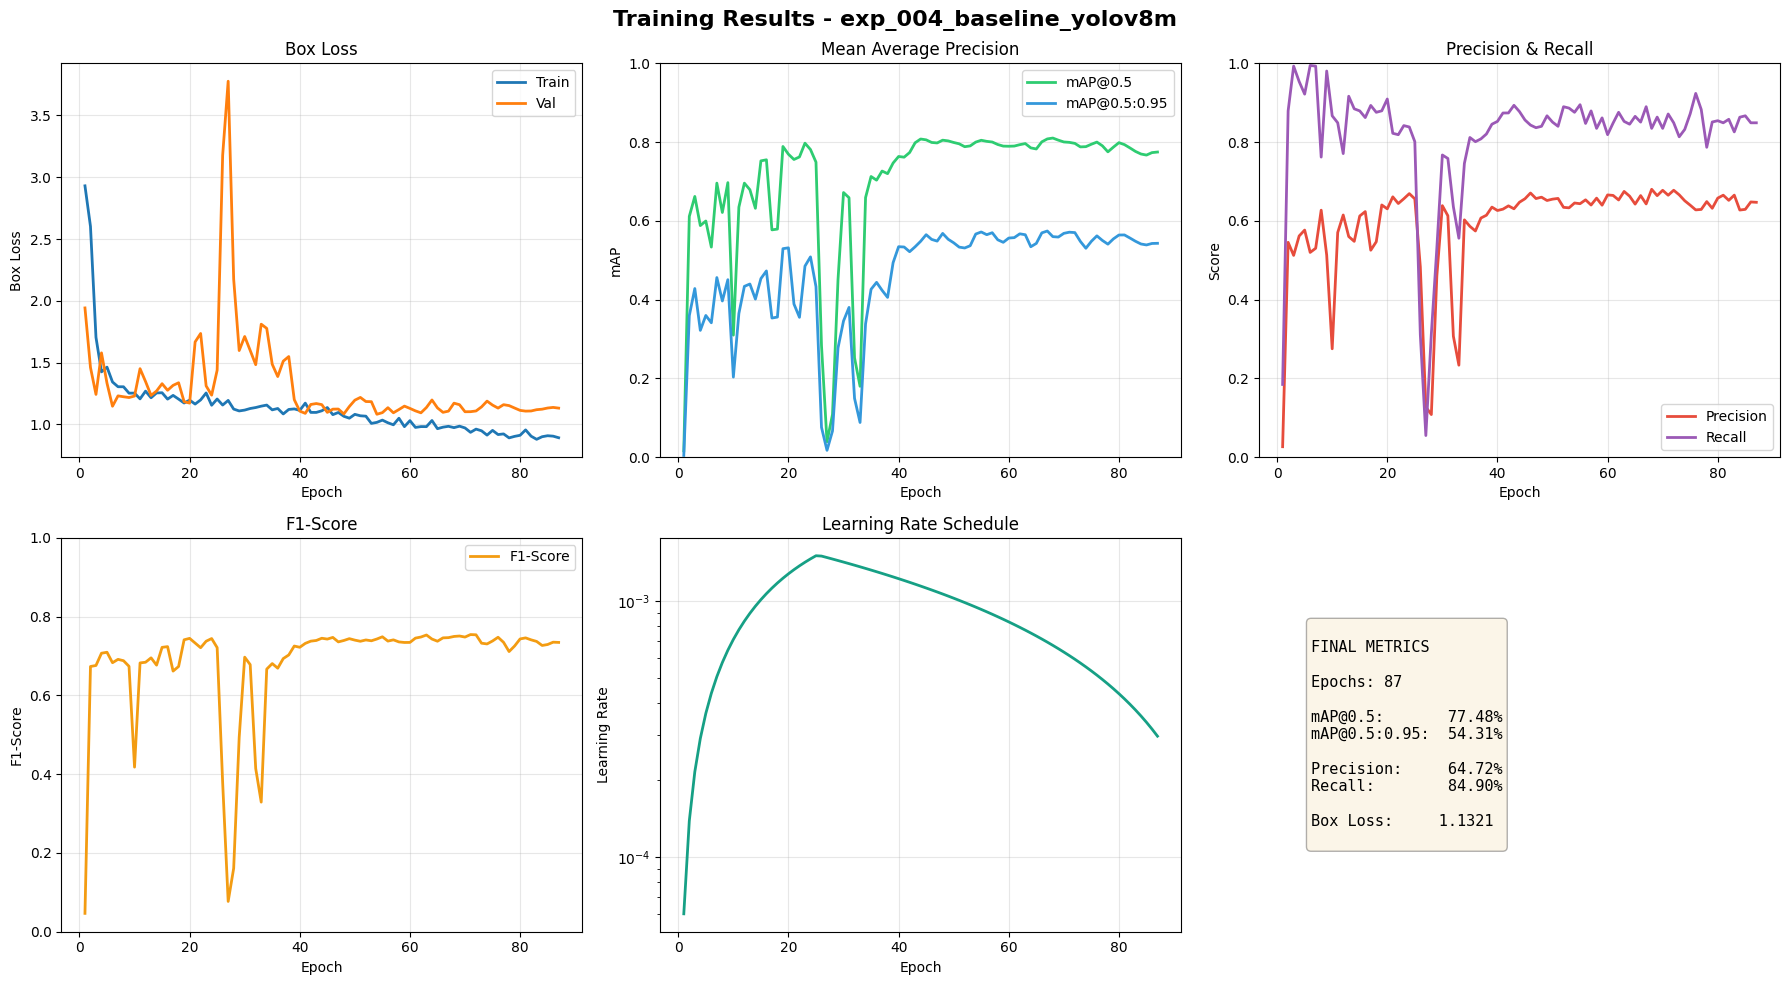


[EARLY STOP] Analysis
Epoch   4: [WARNING] No improvement. Early stop: 1/20
Epoch   5: [WARNING] No improvement. Early stop: 2/20
Epoch   6: [WARNING] No improvement. Early stop: 3/20
Epoch   7: [OK] Improvement! mAP=0.4561 (Early stop reset, was at 3/20)
Epoch   8: [WARNING] No improvement. Early stop: 1/20
Epoch   9: [WARNING] No improvement. Early stop: 2/20
Epoch  10: [WARNING] No improvement. Early stop: 3/20
Epoch  11: [WARNING] No improvement. Early stop: 4/20
Epoch  12: [WARNING] No improvement. Early stop: 5/20
Epoch  13: [WARNING] No improvement. Early stop: 6/20
Epoch  14: [WARNING] No improvement. Early stop: 7/20
Epoch  15: [WARNING] No improvement. Early stop: 8/20
Epoch  16: [OK] Improvement! mAP=0.4730 (Early stop reset, was at 8/20)
Epoch  17: [WARNING] No improvement. Early stop: 1/20
Epoch  18: [WARNING] No improvement. Early stop: 2/20
Epoch  19: [OK] Improvement! mAP=0.5295 (Early stop reset, was at 2/20)
Epoch  21: [WARNING] No improvement. Early stop: 1/20
Epoch

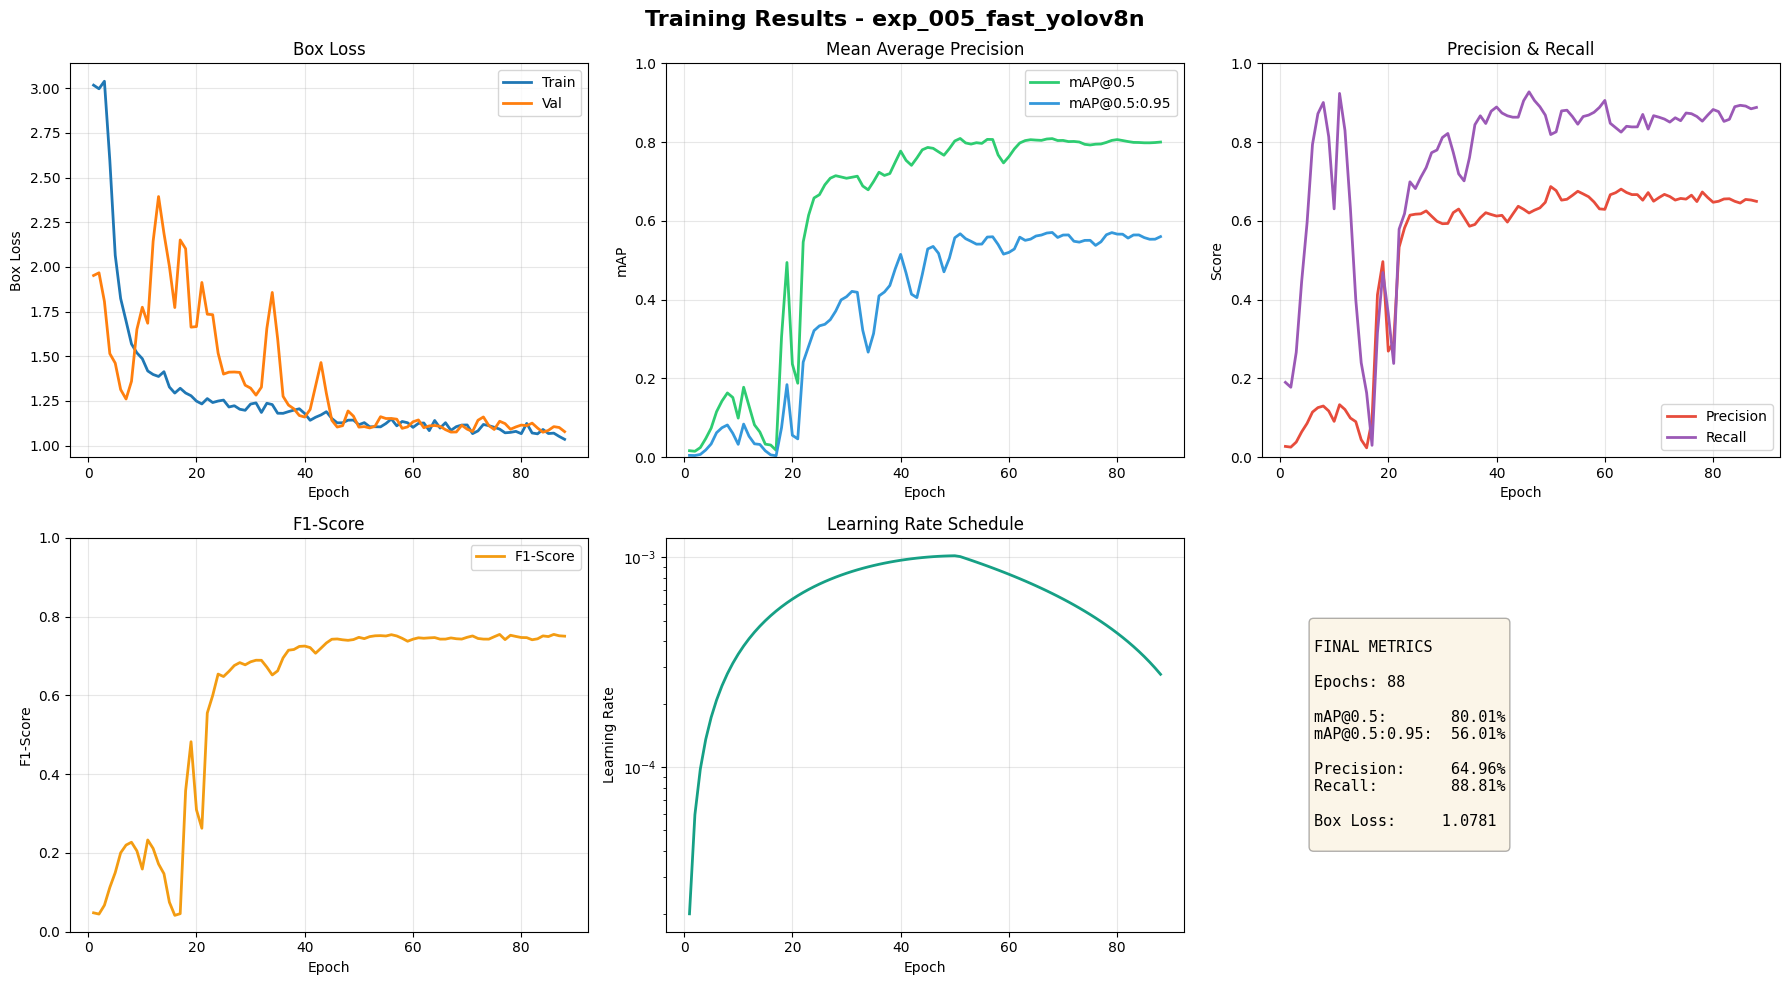


[EARLY STOP] Analysis
Epoch   2: [WARNING] No improvement. Early stop: 1/20
Epoch   3: [OK] Improvement! mAP=0.0070 (Early stop reset, was at 1/20)
Epoch   9: [WARNING] No improvement. Early stop: 1/20
Epoch  10: [WARNING] No improvement. Early stop: 2/20
Epoch  11: [OK] Improvement! mAP=0.0841 (Early stop reset, was at 2/20)
Epoch  12: [WARNING] No improvement. Early stop: 1/20
Epoch  13: [WARNING] No improvement. Early stop: 2/20
Epoch  14: [WARNING] No improvement. Early stop: 3/20
Epoch  15: [WARNING] No improvement. Early stop: 4/20
Epoch  16: [WARNING] No improvement. Early stop: 5/20
Epoch  17: [WARNING] No improvement. Early stop: 6/20
Epoch  18: [WARNING] No improvement. Early stop: 7/20
Epoch  19: [OK] Improvement! mAP=0.1843 (Early stop reset, was at 7/20)
Epoch  20: [WARNING] No improvement. Early stop: 1/20
Epoch  21: [WARNING] No improvement. Early stop: 2/20
Epoch  22: [OK] Improvement! mAP=0.2415 (Early stop reset, was at 2/20)
Epoch  32: [WARNING] No improvement. Earl

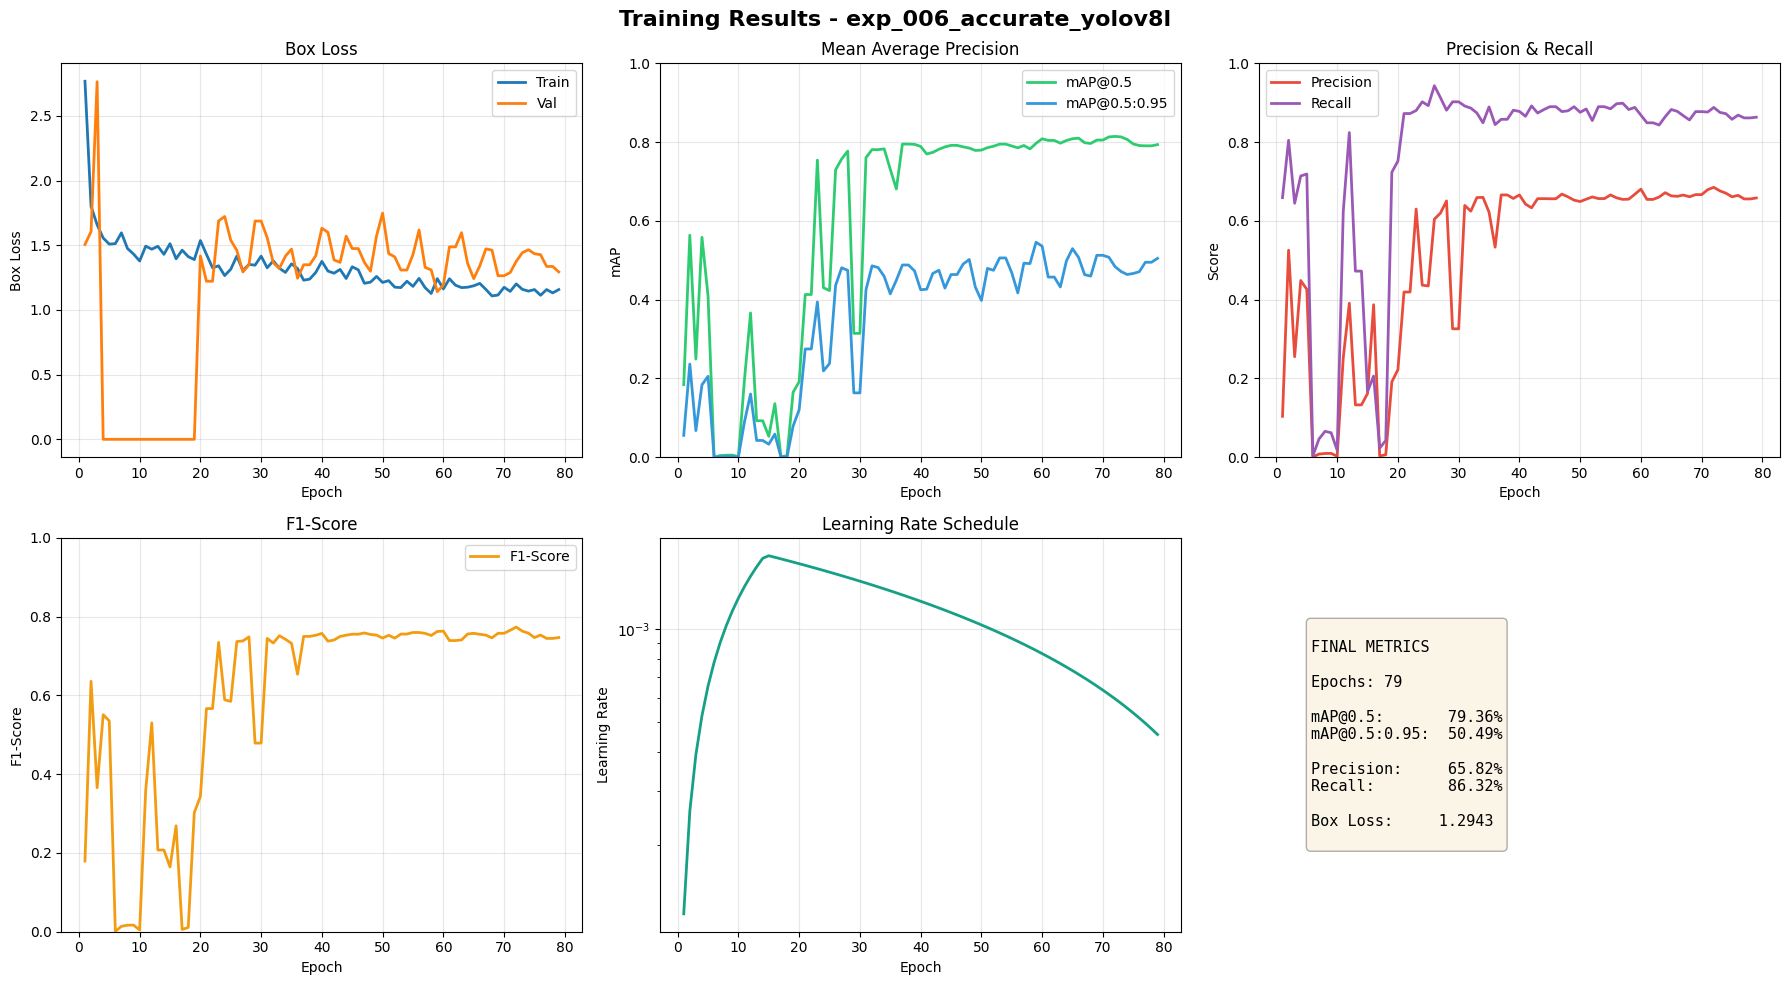


[EARLY STOP] Analysis
Epoch   3: [WARNING] No improvement. Early stop: 1/20
Epoch   4: [WARNING] No improvement. Early stop: 2/20
Epoch   5: [WARNING] No improvement. Early stop: 3/20
Epoch   6: [WARNING] No improvement. Early stop: 4/20
Epoch   7: [WARNING] No improvement. Early stop: 5/20
Epoch   8: [WARNING] No improvement. Early stop: 6/20
Epoch   9: [WARNING] No improvement. Early stop: 7/20
Epoch  10: [WARNING] No improvement. Early stop: 8/20
Epoch  11: [WARNING] No improvement. Early stop: 9/20
Epoch  12: [WARNING] No improvement. Early stop: 10/20
Epoch  13: [WARNING] No improvement. Early stop: 11/20
Epoch  14: [WARNING] No improvement. Early stop: 12/20
Epoch  15: [WARNING] No improvement. Early stop: 13/20
Epoch  16: [WARNING] No improvement. Early stop: 14/20
Epoch  17: [WARNING] No improvement. Early stop: 15/20
Epoch  18: [WARNING] No improvement. Early stop: 16/20
Epoch  19: [WARNING] No improvement. Early stop: 17/20
Epoch  20: [WARNING] No improvement. Early stop: 18

In [ ]:
print(f"\n{'='*80}")
print(f"  ALL EXPERIMENTS COMPLETED ({len(trainers)} experiments)")
print(f"{'='*80}\n")

# Plot results for each experiment
for i, trainer in enumerate(trainers):
    print(f"\n[PLOT] Experiment: {experiments_config[i]['name']}")
    trainer.plot_training_results()
    trainer.monitor_early_stopping()

## 5. View Experiment Results

View the master log with all experiments and their dataset info.

In [ ]:
# ==============================================================================
# SECTION 5: View Experiment Results
# ==============================================================================

import pandas as pd

master_log = Path(EXPERIMENTS_PATH) / 'all_experiments_log.csv'

if master_log.exists():
    df = pd.read_csv(master_log)

    print(f"\n[RESULTS] All Experiments Log ({len(df)} experiments)")
    print("=" * 100)

    # Display relevant columns
    display_cols = [
        'experiment_id',
        'model_variant',
        'num_train_images',
        'num_val_images',
        'num_train_boxes',
        'num_val_boxes',
        'mAP_50',
        'mAP_50_95',
        'precision',
        'recall',
        'f1_score'
    ]

    # Only show columns that exist
    available_cols = [col for col in display_cols if col in df.columns]

    print(df[available_cols].to_string(index=False))
    print("\n" + "=" * 100)
else:
    print("[WARNING] No experiments log found yet. Run experiments first.")


[RESULTS] All Experiments Log (6 experiments)
           experiment_id model_variant  num_train_images  num_val_images  num_train_boxes  num_val_boxes   mAP_50  mAP_50_95  precision   recall  f1_score
exp_001_baseline_yolov8m    yolov8m.pt                52              13             2305            563 0.808043   0.575337   0.641830 0.884845  0.743996
    exp_002_fast_yolov8n    yolov8n.pt                52              13             2305            563 0.809061   0.570920   0.671820 0.832659  0.743642
exp_003_accurate_yolov8l    yolov8l.pt                52              13             2305            563 0.810534   0.578007   0.643463 0.900533  0.750597
exp_004_baseline_yolov8m    yolov8m.pt                52              13             2305            563 0.808043   0.575337   0.641830 0.884845  0.743996
    exp_005_fast_yolov8n    yolov8n.pt                52              13             2305            563 0.809061   0.570920   0.671820 0.832659  0.743642
exp_006_accurate_yolov8

## 6. View Best Model

View the best model across all experiments.

In [ ]:
# ==============================================================================
# SECTION 6: View Best Model
# ==============================================================================

best_model_file = Path(EXPERIMENTS_PATH) / 'best_model_overall.json'

if best_model_file.exists():
    with open(best_model_file, 'r') as f:
        best = json.load(f)

    print(f"\n{'='*70}")
    print(f"  BEST MODEL OVERALL")
    print(f"{'='*70}")
    print(f"\nExperiment ID: {best['experiment_id']}")
    print(f"Model: {best['model_family']} - {best['model_variant']}")
    print(f"\nMetrics:")
    print(f"  mAP@0.5:      {best['mAP_50']*100:.2f}%")
    print(f"  mAP@0.5:0.95: {best['mAP_50_95']*100:.2f}%")
    print(f"\nWeights: {best['weights_path']}")
    print(f"Updated: {best['updated_at']}")
    print(f"\n{'='*70}\n")
else:
    print("[WARNING] No best model found yet. Run experiments first.")


  BEST MODEL OVERALL

Experiment ID: exp_003_accurate_yolov8l
Model: yolov8 - yolov8l.pt

Metrics:
  mAP@0.5:      81.05%
  mAP@0.5:0.95: 57.80%

Weights: /content/drive/MyDrive/cv_project/04_experiments/01_yolov8/exp_003_accurate_yolov8l/training/weights/best.pt
Updated: 2025-11-17 16:19:04




## 7. Plot Specific Experiment (Optional)

In [ ]:
# ==============================================================================
# SECTION 7: Plot Specific Experiment (Optional)
# ==============================================================================

def plot_experiment_by_id(exp_id: str, model_family: str = '01_yolov8'):
    """
    Plot training results for a specific experiment

    Args:
        exp_id: Experiment ID (e.g., 'exp_001_baseline_yolov8m' or just '001')
        model_family: Model family directory (e.g., '01_yolov8', '02_faster_rcnn')

    Usage:
        plot_experiment_by_id('001')  # Plot exp_001
        plot_experiment_by_id('002', model_family='02_faster_rcnn')
    """
    import glob

    # If only number provided, find matching experiment
    if not exp_id.startswith('exp_'):
        pattern = str(Path(EXPERIMENTS_PATH) / model_family / f'exp_{exp_id}_*')
        matches = glob.glob(pattern)
        if matches:
            exp_path = Path(matches[0])
        else:
            print(f"[ERROR] No experiment found with number: {exp_id}")
            return
    else:
        exp_path = Path(EXPERIMENTS_PATH) / model_family / exp_id

    if not exp_path.exists():
        print(f"[ERROR] Experiment not found: {exp_path}")
        return

    # Create temporary trainer to use plotting method
    temp_trainer = ExperimentTrainer(
        experiment_name='temp',
        model_family_dir=model_family
    )
    temp_trainer.experiment_dir = exp_path
    temp_trainer.experiment_id = exp_path.name

    print(f"\n[PLOT] Plotting experiment: {exp_path.name}")
    temp_trainer.plot_training_results()
    temp_trainer.monitor_early_stopping()

## 8. Compare All Experiments (Optional)

In [ ]:
# ==============================================================================
# SECTION 8: Compare All Experiments (Optional)
# ==============================================================================

def plot_all_experiments(model_family: str = '01_yolov8', metric: str = 'mAP50-95'):
    """
    Plot comparison of all experiments in a family

    Args:
        model_family: Model family directory
        metric: Metric to plot ('mAP50-95', 'mAP50', 'precision', 'recall', 'loss')

    Usage:
        plot_all_experiments('01_yolov8', metric='mAP50-95')
        plot_all_experiments('01_yolov8', metric='loss')
    """
    import pandas as pd
    import glob

    family_path = Path(EXPERIMENTS_PATH) / model_family
    exp_pattern = str(family_path / 'exp_*')
    all_exps = sorted(glob.glob(exp_pattern))

    if not all_exps:
        print(f"[WARNING] No experiments found in {model_family}")
        return

    plt.figure(figsize=(15, 8))

    for exp_path in all_exps:
        exp_name = Path(exp_path).name
        results_csv = Path(exp_path) / 'training' / 'results.csv'

        if results_csv.exists():
            df = pd.read_csv(results_csv).fillna(0)
            epochs = df['epoch'].values

            # Select metric
            if metric == 'mAP50-95':
                values = df['metrics/mAP50-95(B)'].values
                ylabel = 'mAP@0.5:0.95'
            elif metric == 'mAP50':
                values = df['metrics/mAP50(B)'].values
                ylabel = 'mAP@0.5'
            elif metric == 'precision':
                values = df['metrics/precision(B)'].values
                ylabel = 'Precision'
            elif metric == 'recall':
                values = df['metrics/recall(B)'].values
                ylabel = 'Recall'
            elif metric == 'loss':
                values = df['val/box_loss'].values
                ylabel = 'Validation Box Loss'
            else:
                print(f"[ERROR] Unknown metric: {metric}")
                return

            plt.plot(epochs, values, label=exp_name, linewidth=2)

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'All Experiments - {ylabel} Comparison', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"[OK] Plotted {len(all_exps)} experiments")


In [ ]:
# ==============================================================================
# SECTION 9: Download Results (Optional)
# ==============================================================================

# Download results from Google Drive
# Note: Results are already saved in Google Drive at EXPERIMENTS_PATH
# This cell is optional - use only if you want to download to Colab instance

from google.colab import files
import subprocess

# Compress all experiments
subprocess.run(['zip', '-r', '/content/all_experiments.zip', EXPERIMENTS_PATH])

print("[OK] All experiments compressed")
print("\n[DOWNLOAD] Downloading...")

files.download('/content/all_experiments.zip')

print("\n[INFO] Contents:")
print("  - all_experiments_log.csv: All experiments comparison")
print("  - best_model_overall.json: Best model configuration")
print("  - 01_yolov8/: YOLOv8 experiments folder")
print("  - Each experiment folder with weights and plots")

[OK] Loading model: /content/drive/MyDrive/cv_project/04_experiments/01_yolov8/exp_006_accurate_yolov8l/training/weights/best.pt

[INFO] Visualizing: tile_0000_3072.png
[INFO] Confidence threshold: 0.5


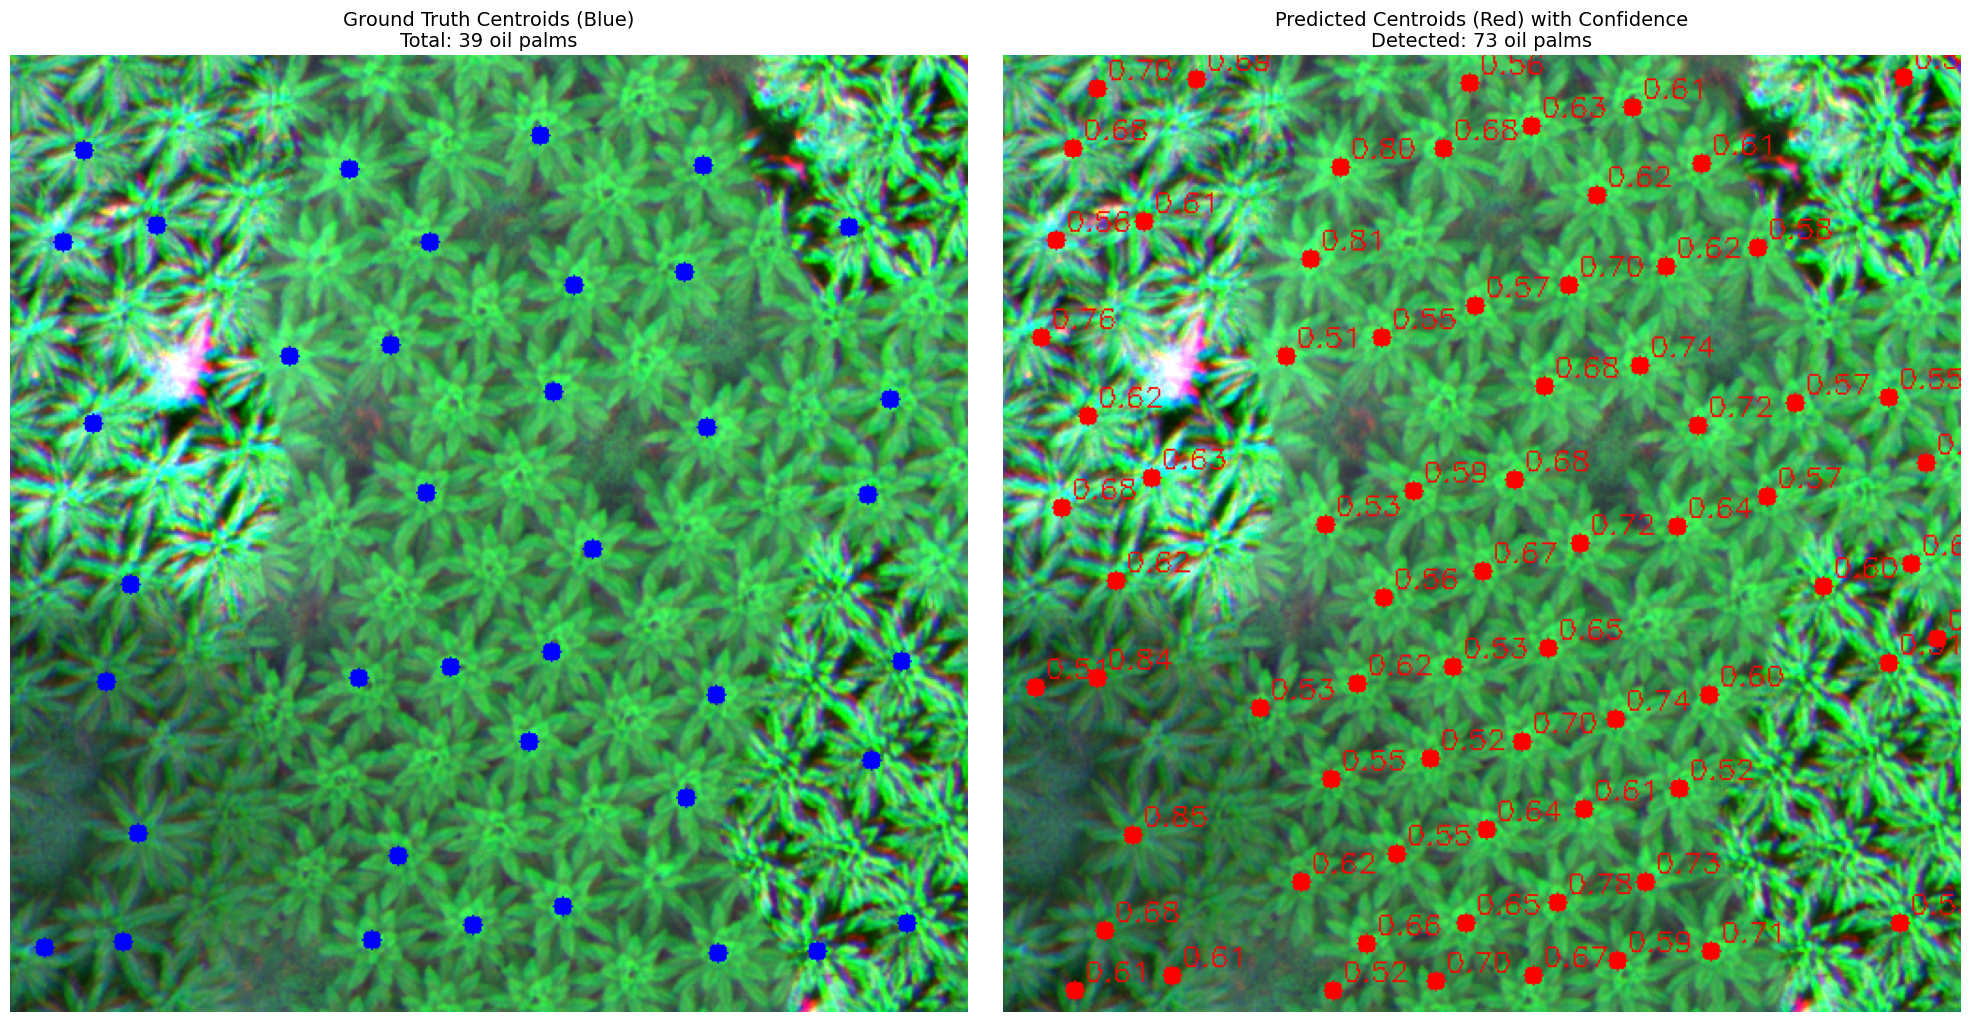


[RESULTS] tile_0000_3072.png
  Ground-truth: 39 oil palms
  Predicted: 73 oil palms
  Difference: +34

  Oil Palm Detection - Advanced Training System
  All sections loaded successfully!


In [ ]:
# ==============================================================================
# SECTION 10: Visualize Predictions (Optional)
# ==============================================================================

import cv2
import glob


def draw_yolo_boxes(image_path, label_path=None, predictions=None,
                    color=(0, 255, 0), show_centroid=False, show_confidence=False):
    """
    Draw YOLO bounding boxes or centroids on an image.

    Parameters
    ----------
    image_path : Path or str
        Path to the image file.

    label_path : Path or None, optional
        Path to the YOLO .txt label file containing ground-truth boxes.
        Each line format: class x_center y_center width height (normalized).

    predictions : ultralytics.yolo.engine.results.Results or None, optional
        YOLO predictions object from `model.predict()`.

    color : tuple of int, optional
        RGB color for drawing boxes or centroids.

    show_centroid : bool, optional
        If True, draw centroids instead of boxes.

    show_confidence : bool, optional
        If True, display confidence values next to predictions.

    Returns
    -------
    image : numpy.ndarray
        Image array with boxes/centroids drawn.
    """
    # Load and convert image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # --- Draw Ground-Truth Boxes ---
    if label_path and label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls, x, y, bw, bh = map(float, parts[:5])
                    x_center, y_center = int(x * w), int(y * h)
                    x1, y1 = int((x - bw / 2) * w), int((y - bh / 2) * h)
                    x2, y2 = int((x + bw / 2) * w), int((y + bh / 2) * h)

                    if show_centroid:
                        cv2.circle(image, (x_center, y_center), 5, color, -1)
                    else:
                        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

    # --- Draw Predicted Boxes ---
    if predictions is not None:
        for box, conf in zip(predictions.boxes.xyxy, predictions.boxes.conf):
            x1, y1, x2, y2 = map(int, box[:4])
            conf_value = float(conf)
            x_center = int((x1 + x2) / 2)
            y_center = int((y1 + y2) / 2)

            if show_centroid:
                cv2.circle(image, (x_center, y_center), 5, color, -1)
                if show_confidence:
                    cv2.putText(image, f"{conf_value:.2f}",
                                (x_center + 5, y_center - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            else:
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                if show_confidence:
                    cv2.putText(image, f"{conf_value:.2f}",
                                (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image


# ===============================
# VISUALIZE GROUND-TRUTH VS PREDICTIONS
# ===============================

# Load best model from the best experiment
best_weights_pattern = str(Path(EXPERIMENTS_PATH) / '01_yolov8' / 'exp_*' / 'training' / 'weights' / 'best.pt')
available_weights = glob.glob(best_weights_pattern)

if available_weights:
    # Use the most recent one (last in sorted list)
    best_weights = sorted(available_weights)[-1]
    print(f"[OK] Loading model: {best_weights}\n")

    model = YOLO(best_weights)

    # Select validation images and labels
    val_images_dir = Path(DATASET_PATH) / 'images' / 'val'
    val_labels_dir = Path(DATASET_PATH) / 'labels' / 'val'
    val_images = list(val_images_dir.glob('*.png')) + list(val_images_dir.glob('*.jpg'))

    if val_images:
        # Choose image to visualize (change index to see different images)
        test_image = val_images[0]  # Change index: 0, 1, 2, etc.
        label_path = val_labels_dir / (test_image.stem + '.txt')

        print(f"[INFO] Visualizing: {test_image.name}")
        print(f"[INFO] Confidence threshold: 0.5")

        # Run prediction with adjustable confidence threshold
        results = model.predict(source=str(test_image), conf=0.5, verbose=False)
        preds = results[0]

        # Draw ground-truth centroids (blue)
        img_labels = draw_yolo_boxes(
            test_image,
            label_path=label_path,
            color=(0, 0, 255),  # Blue for ground-truth
            show_centroid=True
        )

        # Draw predicted centroids (red) with confidence
        img_preds = draw_yolo_boxes(
            test_image,
            predictions=preds,
            color=(255, 0, 0),  # Red for predictions
            show_centroid=True,
            show_confidence=True
        )

        # Count ground-truth boxes
        gt_count = 0
        if label_path.exists():
            with open(label_path, 'r') as f:
                gt_count = len(f.readlines())

        # Display side-by-side comparison
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))

        axs[0].imshow(img_labels)
        axs[0].set_title(f"Ground Truth Centroids (Blue)\nTotal: {gt_count} oil palms", fontsize=14)
        axs[0].axis('off')

        axs[1].imshow(img_preds)
        axs[1].set_title(f"Predicted Centroids (Red) with Confidence\nDetected: {len(preds.boxes)} oil palms", fontsize=14)
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n[RESULTS] {test_image.name}")
        print(f"  Ground-truth: {gt_count} oil palms")
        print(f"  Predicted: {len(preds.boxes)} oil palms")
        print(f"  Difference: {len(preds.boxes) - gt_count:+d}")
    else:
        print("[WARNING] No validation images found")
else:
    print("[WARNING] No trained models found. Run experiments first.")


# ==============================================================================
# END OF SCRIPT
# ==============================================================================

print("\n" + "="*80)
print("  Oil Palm Detection - Advanced Training System")
print("  All sections loaded successfully!")
print("="*80)
